In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g6c7PTC-UXz9X4t900q_A7_ovFMFQ5Pr1n_h_06xTudreKxuZpTYNM
Mounted at /content/drive


In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/cuda/diabetes.csv')

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
!pip install torch

In [5]:
import torch
torch.cuda.is_available()

True

In [6]:
a = torch.rand(10000,10000)
b = torch.rand(10000,10000)

import time
start = time.time()
a.matmul(b)
end = time.time()
print("{} seconds".format(end - start))

25.974895238876343 seconds


In [7]:
a = a.cuda()
b = b.cuda()

start = time.time()
a.matmul(b)
end = time.time()
print("{} seconds".format(end - start))


0.011646747589111328 seconds


In [8]:
print(type(a),type(b))

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [154]:
X = df.drop('Outcome',axis=1)
y = df['Outcome']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)
##### Creating Tensors
X_train=torch.FloatTensor(X_train_scaled).cuda()
X_test=torch.FloatTensor(X_test_scaled).cuda()
y_train=torch.LongTensor(y_train.values).cuda()
y_test=torch.LongTensor(y_test.values).cuda()



In [301]:
from torch import nn
import torch.nn.functional as F

class ANN_Model(nn.Module):
    def __init__(self,input_features=8,hidden1=6,hidden2=4,out_features=2):
        super().__init__()
        self.f_connected1=nn.Sequential( nn.Linear(input_features,hidden1), nn.ReLU())
        self.f_connected2=nn.Sequential( nn.Linear(hidden1,hidden2),nn.ReLU())
        self.out=nn.Linear(hidden2,out_features)
    def forward(self,x):
        x=F.relu(self.f_connected1(x))
        x=F.relu(self.f_connected2(x))
        x=self.out(x)
        return x

In [302]:
####instantiate my ANN_model
torch.manual_seed(20)
model=ANN_Model()
print(model)

ANN_Model(
  (f_connected1): Sequential(
    (0): Linear(in_features=8, out_features=6, bias=True)
    (1): ReLU()
  )
  (f_connected2): Sequential(
    (0): Linear(in_features=6, out_features=4, bias=True)
    (1): ReLU()
  )
  (out): Linear(in_features=4, out_features=2, bias=True)
)


In [277]:
model.parameters

<bound method Module.parameters of ANN_Model(
  (f_connected1): Sequential(
    (0): Linear(in_features=8, out_features=6, bias=True)
    (1): ReLU()
  )
  (f_connected2): Sequential(
    (0): Linear(in_features=6, out_features=4, bias=True)
    (1): ReLU()
  )
  (out): Linear(in_features=4, out_features=2, bias=True)
)>

In [91]:
y_train.device

device(type='cuda', index=0)

In [303]:
for i in model.parameters():
    print(i.is_cuda)

False
False
False
False
False
False


In [304]:
model=model.cuda()

In [305]:
model

ANN_Model(
  (f_connected1): Sequential(
    (0): Linear(in_features=8, out_features=6, bias=True)
    (1): ReLU()
  )
  (f_connected2): Sequential(
    (0): Linear(in_features=6, out_features=4, bias=True)
    (1): ReLU()
  )
  (out): Linear(in_features=4, out_features=2, bias=True)
)

In [306]:
for i in model.parameters():
    print(i.is_cuda)

True
True
True
True
True
True


In [307]:
loss_function=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.003)

In [308]:
import time
start_time=time.time()
epochs=8000
final_losses=[]
for i in range(epochs):
    i=i+1
    y_pred=model.forward(X_train)
    loss=loss_function(y_pred,y_train)
    final_losses.append(loss)
    if i%10==1:
        print("Epoch number: {} and the loss : {}".format(i,loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print(time.time()-start_time)

Epoch number: 1 and the loss : 0.6674039959907532
Epoch number: 11 and the loss : 0.634199321269989
Epoch number: 21 and the loss : 0.6050453782081604
Epoch number: 31 and the loss : 0.5806847214698792
Epoch number: 41 and the loss : 0.5587883591651917
Epoch number: 51 and the loss : 0.5399642586708069
Epoch number: 61 and the loss : 0.524530291557312
Epoch number: 71 and the loss : 0.5115704536437988
Epoch number: 81 and the loss : 0.5012460947036743
Epoch number: 91 and the loss : 0.4928086996078491
Epoch number: 101 and the loss : 0.4860762357711792
Epoch number: 111 and the loss : 0.4804898202419281
Epoch number: 121 and the loss : 0.47572827339172363
Epoch number: 131 and the loss : 0.47161364555358887
Epoch number: 141 and the loss : 0.4677991271018982
Epoch number: 151 and the loss : 0.463825523853302
Epoch number: 161 and the loss : 0.46017584204673767
Epoch number: 171 and the loss : 0.45729392766952515
Epoch number: 181 and the loss : 0.45453891158103943
Epoch number: 191 and

Text(0.5, 0, 'Epoch')

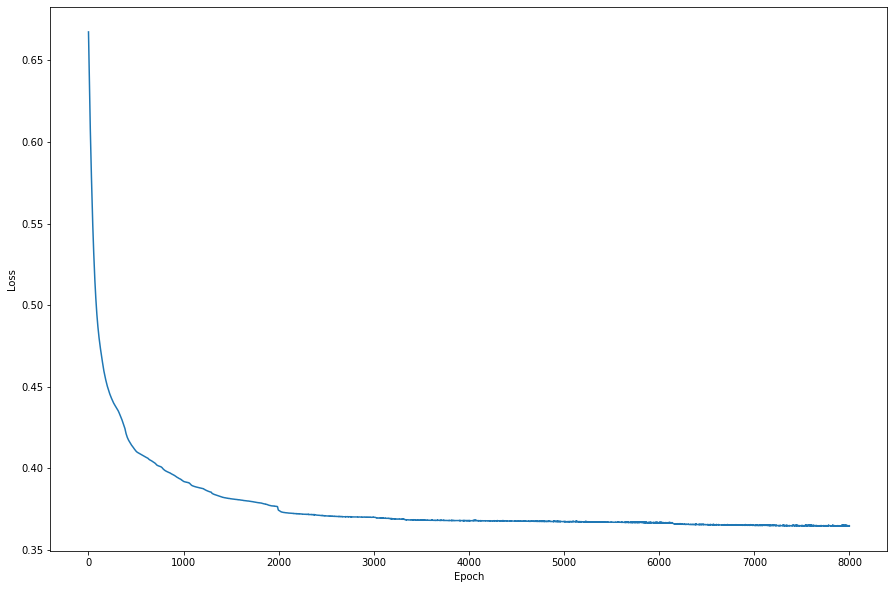

In [309]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.plot(range(epochs),final_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [310]:
predictions=[]
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_pred=model(data)
        predictions.append(y_pred.argmax().item())
        print(y_pred.argmax().item())

1
0
0
1
0
0
1
1
1
0
1
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
1
1
1
0
0
0
0
0
0
1
1
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
1
1
0
0
0
0
1
0
0
0
0
1
0
0
1
1
1
1
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0


In [140]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pred1)
cm

NameError: ignored

In [25]:
type(predictions)

list

In [26]:
type(y_test)

torch.Tensor

In [311]:
y_test1 = y_test.cpu().numpy()

In [312]:
y_test1

array([1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0])

In [313]:
import numpy as np
predictions1 = np.array(predictions)

In [314]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test1,predictions1)
cm

array([[98,  9],
       [18, 29]])

Text(69.0, 0.5, 'Predicted Values')

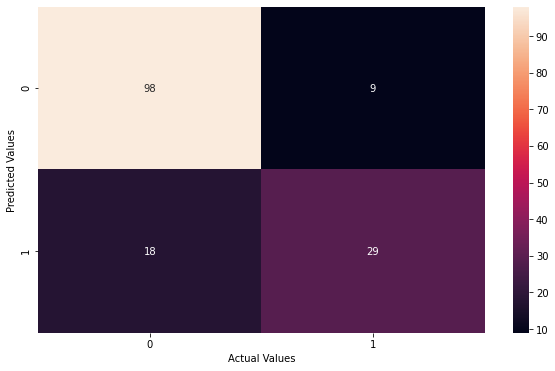

In [315]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=True)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

In [316]:
from sklearn.metrics import accuracy_score
score=accuracy_score(y_test1,predictions1)
score

0.8246753246753247

In [34]:
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [35]:
loss

tensor(0.9706, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [36]:
z

tensor([-0.3567,  2.2005, -2.5459], grad_fn=<AddBackward0>)

In [38]:
w.shape

torch.Size([5, 3])

In [39]:
print('Gradient function for z =',z.grad_fn)
print('Gradient function for loss =', loss.grad_fn)

Gradient function for z = <AddBackward0 object at 0x7fac71593810>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward object at 0x7fac71593b10>


In [40]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.1373, 0.3001, 0.0242],
        [0.1373, 0.3001, 0.0242],
        [0.1373, 0.3001, 0.0242],
        [0.1373, 0.3001, 0.0242],
        [0.1373, 0.3001, 0.0242]])
tensor([0.1373, 0.3001, 0.0242])


In [41]:
w

tensor([[-0.1454,  1.8462, -0.3794],
        [-0.3309,  0.1217, -1.7563],
        [ 0.3290,  0.0075, -0.9869],
        [-2.1235, -0.5774, -0.7646],
        [ 1.0021,  0.1666,  1.0439]], requires_grad=True)

In [42]:
b

tensor([0.9120, 0.6360, 0.2973], requires_grad=True)

In [43]:
m = nn.Dropout(p=0.2)
input = torch.randn(20, 16)
output = m(input)

In [45]:
output.shape

torch.Size([20, 16])

In [46]:
input.shape

torch.Size([20, 16])

In [48]:
input.size()

torch.Size([20, 16])